In [1]:
import time
import pandas as pd
import numpy as np
from progressbar import ProgressBar, Bar, Percentage

from zipfile import ZipFile
import os
import cv2
from PIL import Image

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

from sklearn.model_selection import train_test_split

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint

In [2]:
with ZipFile('xray_images.zip', 'r') as zip_ref:
    zip_ref.extractall('xray_images')

In [3]:
def encode_images():
    
    X = []
    y = []

    directories = ['xray_images/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/', 
                  'xray_images/Montgomery/MontgomerySet/CXR_png/']
    n_files = 0

    for directory in directories:
        n_files += len(os.listdir(directory))

    counter = 0

    bar = ProgressBar(maxval=n_files+1, widgets=[Bar('=', '[', ']'), ' ', Percentage()])
    bar.start()

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.png'):
                X.append(cv2.imread(directory + filename))
                y.append(int(filename[-5]))
                counter += 1
                bar.update(counter)

    bar.finish()
    
    return np.array(X), np.array(y)

In [4]:
X, y = encode_images()

[========================================================================] 100%
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [5]:
def plot_dimensions(X, save=False):
    
    heights = [i.shape[0] for i in X]
    widths = [i.shape[1] for i in X]
    
    dimensions = [widths, heights]
    xlabels = ['heights (pixels)', 'widths (pixels)']
    
    fig = plt.figure(figsize=(14, 6))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Avenir'
    for i in range(len(dimensions)):
        print((min(dimensions[i]), max(dimensions[i])), min(dimensions[i]) == max(dimensions[i]))
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(dimensions[i], bins=20)
        ax.set_xlabel(xlabels[i], fontsize=14)
    
    plt.tight_layout()
    plt.show()
    if save:
        fig.savefig('xray_visualisations/dimensions.png')

(1130, 4892) False
(948, 4892) False


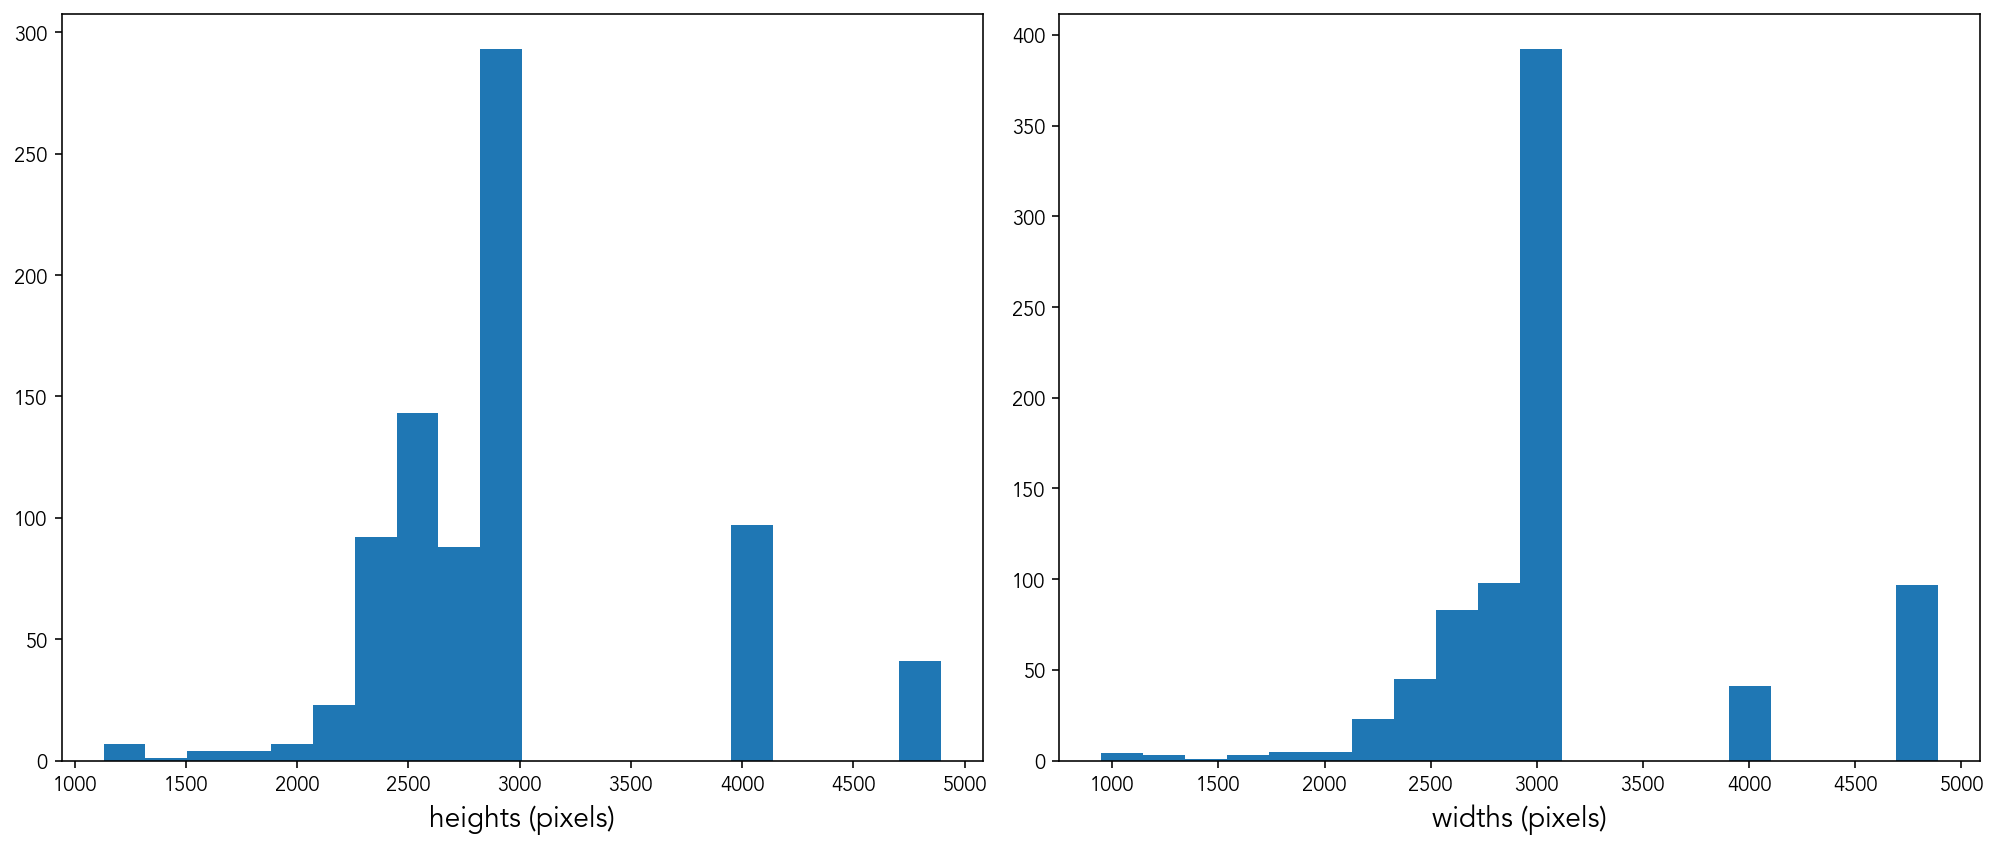

In [6]:
plot_dimensions(X, save=True)

In [7]:
widths = [i.shape[0] for i in X]
heights = [i.shape[1] for i in X]
min(min(widths), min(heights))

948

In [8]:
def resize_encode_images():
    
    X = []
    y = []

    directories = ['xray_images/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/', 
                  'xray_images/Montgomery/MontgomerySet/CXR_png/']
    n_files = 0

    for directory in directories:
        n_files += len(os.listdir(directory))

    counter = 0

    bar = ProgressBar(maxval=n_files+1, widgets=[Bar('=', '[', ']'), ' ', Percentage()])
    bar.start()

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.endswith('.png'):
                img = Image.open(directory + filename)
                img = img.resize((1024, 1024))
                img.save(directory + filename)
                X.append(cv2.imread(directory + filename))
                y.append(int(filename[-5]))
                counter += 1
                bar.update(counter)

    bar.finish()
    
    return np.array(X), np.array(y)

In [9]:
X, y = resize_encode_images()

[========================================================================] 100%


(1024, 1024) True
(1024, 1024) True


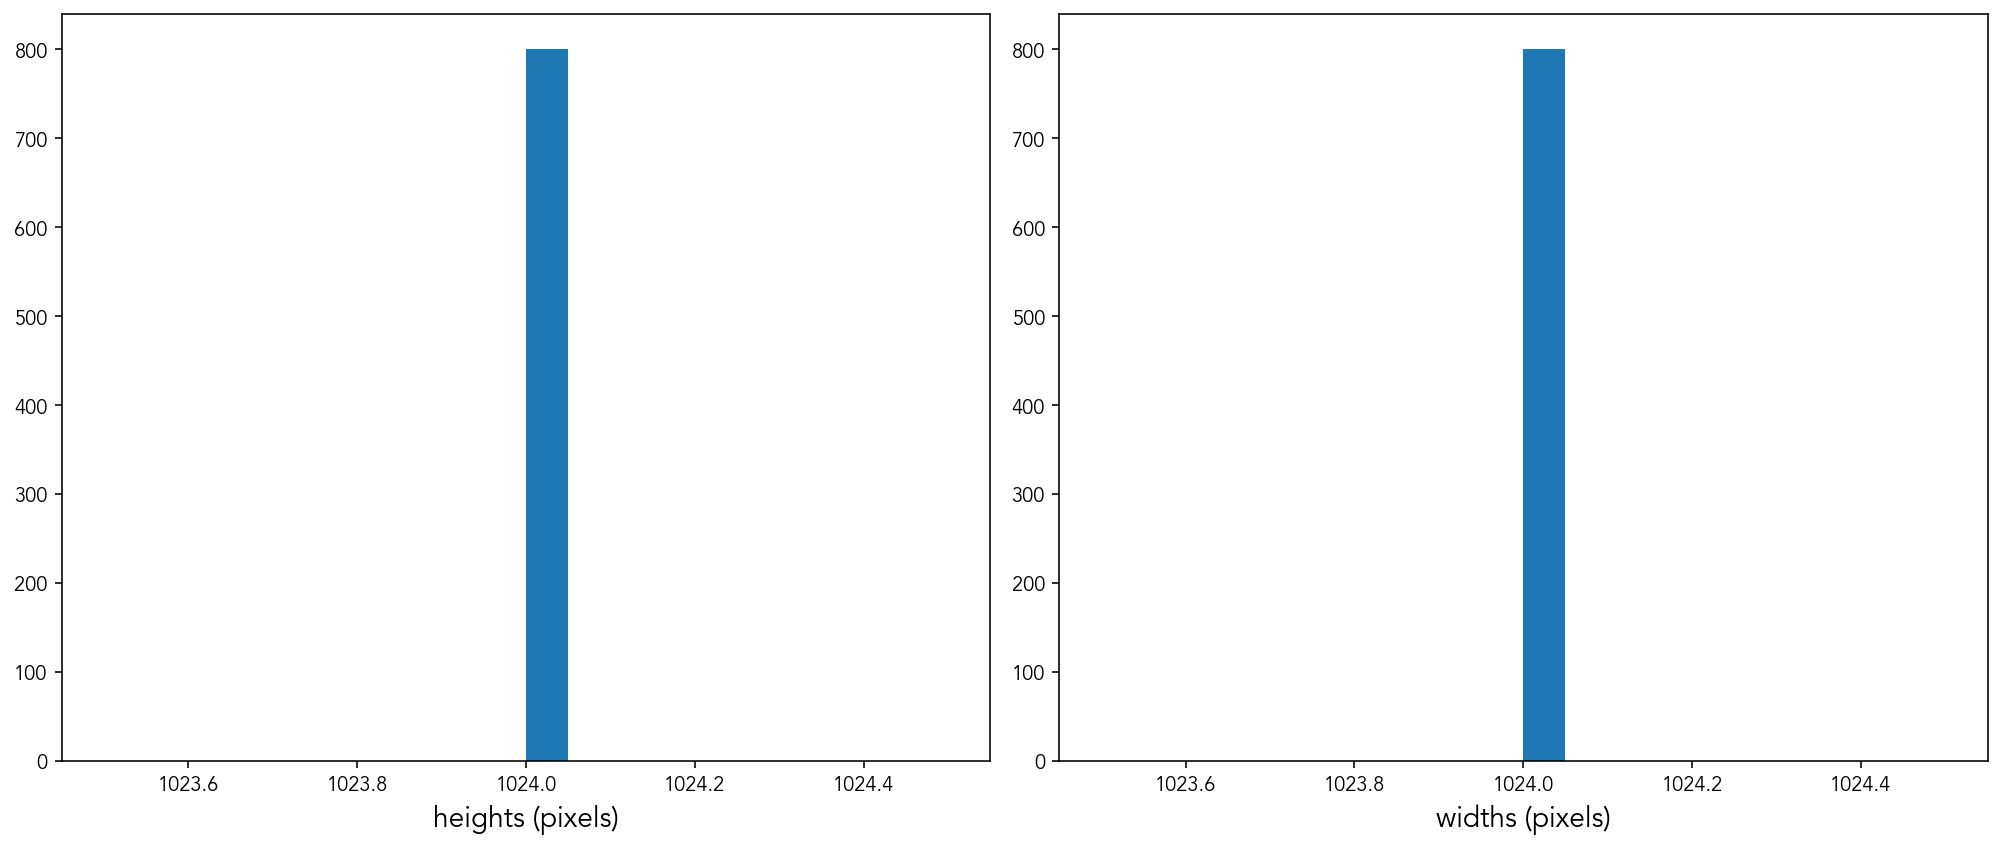

In [10]:
plot_dimensions(X)

In [11]:
set(y) == {0, 1}

True

In [12]:
np.mean(y)

0.4925

In [13]:
def plot_target(y):
    
    k, v = np.unique(y, return_counts=True)
    y_counts = dict(zip(k, v))
    
    fig = plt.figure(figsize=(8, 8))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Avenir'
    ax = fig.add_subplot(1, 1, 1)
    ax.pie(y_counts.values(), startangle=90, colors=['lightblue', 'steelblue'], 
          explode=(0.05, 0), autopct='%.2f%%', wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, 
          textprops={'fontsize': 18, 'fontweight': 'bold'})
    circle1 = Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markeredgecolor='black', 
                     markersize=22)
    circle2 = Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markeredgecolor='black', 
                     markersize=22)
    ax.legend(labels=y_counts.keys(), handles=[circle1, circle2], fontsize=18, framealpha=0)
    
    plt.tight_layout()
    plt.show()
    fig.savefig('xray_visualisations/target.png')

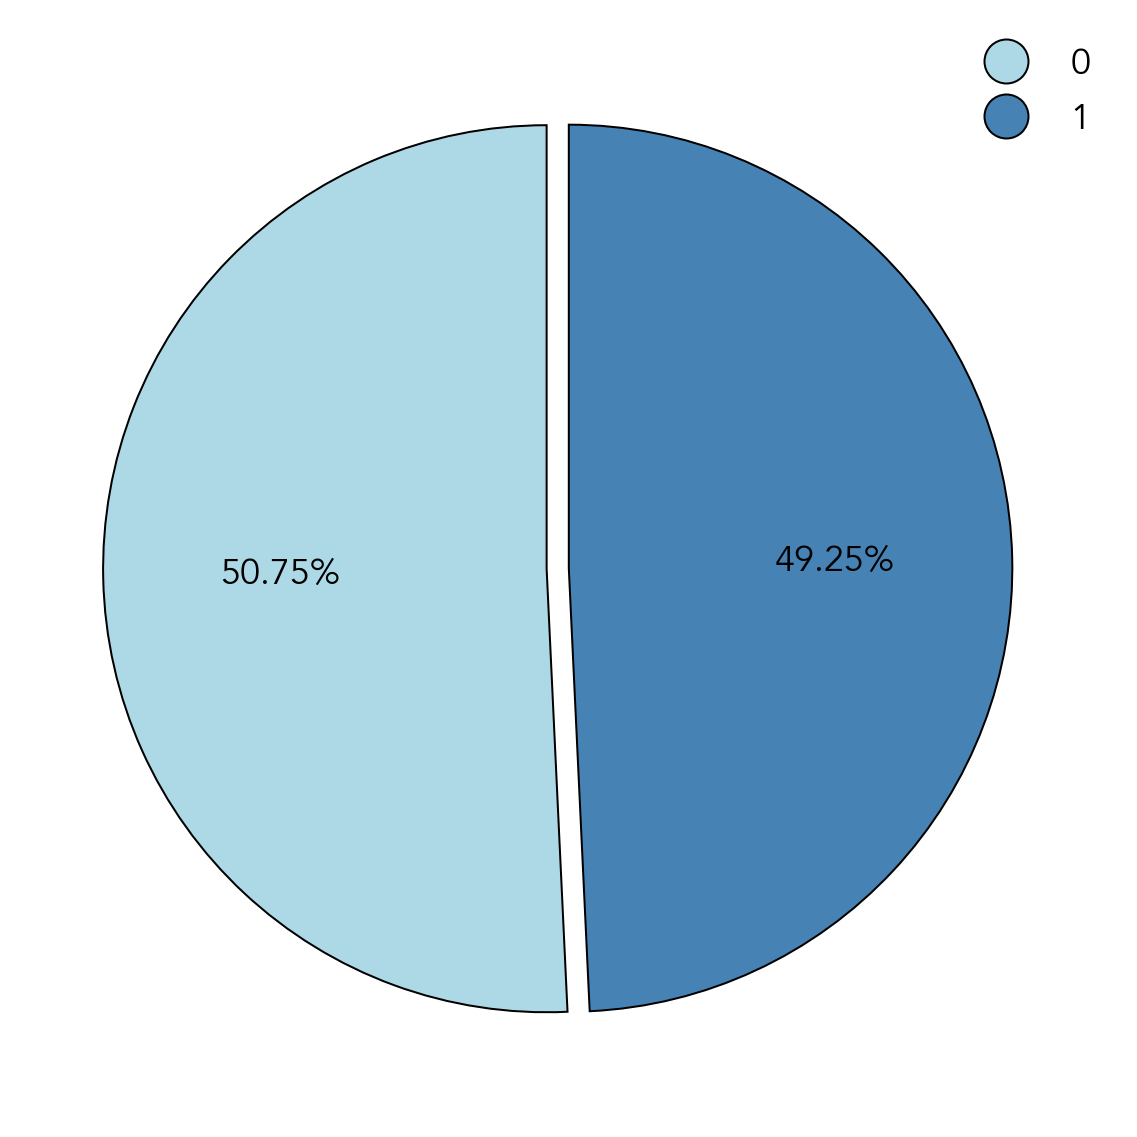

In [14]:
plot_target(y)

In [15]:
train_size = 0.6
val_size = 0.2
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(val_size + test_size), random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=(test_size / (val_size + test_size)), 
                                                random_state=42)

print('Training: {}; Validation: {}; Testing: {}'.format((len(X_train), len(y_train)), (len(X_val), len(y_val)), 
                                                      (len(X_test), len(y_test))))

Training: (480, 480); Validation: (160, 160); Testing: (160, 160)


In [16]:
y_train = keras.utils.to_categorical(y_train, len(set(y)))
y_val = keras.utils.to_categorical(y_val, len(set(y)))
y_test = keras.utils.to_categorical(y_test, len(set(y)))

print(y_train.shape, y_val.shape, y_test.shape)

(480, 2) (160, 2) (160, 2)


In [17]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=X[0].shape))
model.add(MaxPooling2D(pool_size=4))
model.add(Flatten())
model.add(Dense(len(set(y)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 1024, 16)    208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1048576)           0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2097154   
Total params: 2,097,362
Trainable params: 2,097,362
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [19]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

start_time = time.time()

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpointer], 
          verbose=1, shuffle=True)

print('Time elapsed:')
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))

Epoch 1/10
15/15 [==============================] - 173s 11s/step - loss: 56619.4373 - accuracy: 0.4746 - val_loss: 9512.7441 - val_accuracy: 0.5312

Epoch 00001: val_loss improved from inf to 9512.74414, saving model to model.weights.best.hdf5
Epoch 2/10
15/15 [==============================] - 158s 10s/step - loss: 17898.7800 - accuracy: 0.4806 - val_loss: 15657.3594 - val_accuracy: 0.4625

Epoch 00002: val_loss did not improve from 9512.74414
Epoch 3/10
15/15 [==============================] - 160s 10s/step - loss: 11005.5641 - accuracy: 0.4915 - val_loss: 8044.7461 - val_accuracy: 0.5312

Epoch 00003: val_loss improved from 9512.74414 to 8044.74609, saving model to model.weights.best.hdf5
Epoch 4/10
15/15 [==============================] - 174s 12s/step - loss: 5596.7574 - accuracy: 0.5692 - val_loss: 3898.9363 - val_accuracy: 0.5312

Epoch 00004: val_loss improved from 8044.74609 to 3898.93628, saving model to model.weights.best.hdf5
Epoch 5/10
15/15 [=============================

In [20]:
print('Accuracy: {}'.format(str(round(model.evaluate(X_test, y_test, verbose=0)[1], 4))))

Accuracy: 0.7625
